<a href="https://colab.research.google.com/github/hidt4/python-compchem-book/blob/main/compchem_book_ch10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 10章 反応機構を計算してみよう

### 環境構築

#### Google Colab上にPsi4をインストール
2023年8月時点では問題なく動作していましたが

今後のColabの開発動向次第では動作しなくなる可能性があります

In [ ]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!conda install -q -y -c psi4 psi4 python=3.10
import sys
sys.path.append('/usr/local/lib/python3.10/site-packages')

--2024-02-24 11:02:53--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.16.245.55, 104.16.246.55, 2606:4700::6810:f537, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.16.245.55|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2024-02-24 11:02:53--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...
                                                                                  
Installing base environment.

In [ ]:
import os
import datetime
import numpy as np
import pandas as pd
import psi4

print(f'current time: {datetime.datetime.now()}')
print(f'python version:\n{sys.version}')
print(f'numpy version: {np.__version__}')
print(f'pandas version: {pd.__version__}')
print(f'psi4 version: {psi4.__version__}')

/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'allow_mutation' has been removed
  warnings.warn(message, UserWarning)


PydanticImportError: `BaseSettings` has been moved to the `pydantic-settings` package. See https://docs.pydantic.dev/2.6/migration/#basesettings-has-moved-to-pydantic-settings for more details.

For further information visit https://errors.pydantic.dev/2.6/u/import-error

#### 必要なライブラリと関数の定義

In [ ]:
# 振動数可視化のためのライブラリ
!pip install py3Dmol
import py3Dmol

!git clone https://github.com/duerrsimon/normal-mode-jupyter.git
sys.path.append('/content/normal-mode-jupyter')
from helpers import show_normal_modes

In [ ]:
def show_3D(mol: psi4.core.Molecule) -> py3Dmol.view:
    """
    Psi4のMoleculeオブジェクトをpy3Dmolで描画する
    Args:
        mol: 描画対象の分子

    Returns:
        py3Dmol.view: py3Dmolの描画オブジェクト

    """
    view = py3Dmol.view(width=400, height=400)
    xyz = mol.save_string_xyz_file()
    view.addModel(xyz, 'xyz')
    view.setStyle({'stick': {}})
    view.setBackgroundColor('#e1e1e1')
    view.zoomTo()

    return view.show()

In [ ]:
def optfreq(mol: psi4.core.Molecule,
            theory: str) -> list[float, psi4.core.Wavefunction]:
    """
    分子の構造最適化と振動数計算を行う

    Args:
        mol (psi4.core.Molecule): 計算対象の分子
        theory: 計算レベル

    Returns:
        float: エネルギー
        psi4.core.Wavefunction: 計算のWavefunction

    """
    _, wfn = psi4.optimize(theory,
                           molecule=mol,
                           return_wfn=True)
    energy, wfn = psi4.frequency(theory,
                                 molecule=mol,
                                 ref_gradient=wfn.gradient(),
                                 return_wfn=True)

    return [energy, wfn]


def get_freqs(wavefunction: psi4.core.Wavefunction) -> np.ndarray:
    """
    Wavefunctionオブジェクトから振動数を取り出す
    Args:
        wavefunction: 対象のWavefunctionオブジェクト

    Returns:
        振動数のarrray

    """
    return wavefunction.frequencies().to_array()


#### 計算資源の設定

In [ ]:
# 計算資源の確認（CPU, RAM）
!cat /proc/cpuinfo

In [ ]:
!cat /proc/meminfo

In [ ]:
n_cpu = os.cpu_count()
ram = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES') / (1024 ** 3)

In [ ]:
# 環境に応じて計算資源を設定
psi4.set_num_threads(n_cpu)
psi4.set_memory(f'{ram * 0.9: .0f}GB')

### 10.2　遷移状態を計算してみよう

#### 1,2-ジクロロエタン

In [ ]:
psi4.set_output_file('dce_ts.log')

# 二面角0度の初期構造
dce = psi4.geometry('''
0 1
 C                 -2.52697099    1.46473027    0.00000000
 H                 -2.17029815    1.96912846   -0.87365150
 H                 -3.59697099    1.46474345    0.00000000
 C                 -2.01365528    0.01279812    0.00000000
 H                 -2.84588587   -0.65972864    0.00000086
 H                 -1.41921341   -0.15534323   -0.87365174
 Cl                -1.94029417    2.29439458    1.43703425
 Cl                -1.03587983   -0.26377103    1.43703329
 ''')

In [ ]:
# 遷移状態計算に設定
psi4.set_options({'opt_type': 'TS',
                  'normal_modes_write': True})

In [ ]:
# 構造最適化・振動数計算
_, wfn_dce = optfreq(dce, 'hf/sto-3g')

Streaming output truncated to the last 5000 lines.
	  -0.010864  -0.008558   0.008458  -0.007139   0.003329   0.020345   0.004748
	   0.000987   0.001016  -0.001658   0.001990   0.000975   0.001004   0.001854
	  -0.006392   0.005865  -0.000976   0.000299  -0.006801  -0.005144   0.005541
	   0.007129  -0.001076  -0.000070  -0.005490   0.006918  -0.008986  -0.009254
	   0.004922  -0.009203  -0.009471   0.004705   0.005015   0.004748   0.018923

INFO:psi4.optking.opt_helper:
	         Geometry (au)                                       Gradient (au)
  -1.4838601478   1.0442022980  -1.8212518688		   0.0021126349  -0.0005221843   0.0034489962
  -0.8187848599   1.9675510417  -3.5448763162		   0.0000917276  -0.0005811001  -0.0031949957
  -3.5483314788   1.0031600619  -1.8779659762		  -0.0025238597  -0.0013210503  -0.0016433188
  -0.4977741579  -1.7466389679  -1.8228260145		   0.0015377632   0.0016959715   0.0029581301
  -2.1302205724  -3.0106686455  -1.8727714792		  -0.0026812011  -0.00036404

Optimizer: Optimization complete!


INFO:psi4.driver.driver:Return hessian(): -986.2910661905431
INFO:psi4.driver.driver:[[ 0.78435610  0.02304687 -0.06221960 -0.12261241 -0.05899042  0.11097225 -0.46908110 -0.00227870 -0.00026076
  -0.13190387  0.06205825  0.01435906  0.01317952 -0.02556656 -0.00406871 -0.00156819  0.02430614 -0.00089636
  -0.06487034 -0.03813016 -0.05350352 -0.00749971  0.01555459 -0.00438236]
 [ 0.02304687  0.62475931 -0.08106241 -0.05740739 -0.15029013  0.15959728 -0.00167379 -0.06735522  0.01122754
   0.05028497 -0.27100885 -0.00571835  0.01576304 -0.02105604 -0.00195947  0.00097664 -0.00681762  0.00502648
  -0.03441601 -0.10353402 -0.08961328  0.00342568 -0.00469743  0.00250220]
 [-0.06221960 -0.08106241  0.68224245  0.10941453  0.15733878 -0.33270079  0.00256714  0.00991313 -0.06916845
   0.00756368  0.01350527 -0.09862269  0.00020813  0.00280077  0.00367673  0.00521369 -0.02913977  0.00419229
  -0.05136431 -0.09567514 -0.18457621 -0.01138325  0.02231936 -0.00504333]
 [-0.12261241 -0.05740739  0.1

In [ ]:
print(get_freqs(wfn_dce))

[-183.03426720  204.70100744  507.44370977  830.24726561  884.97904215
  990.49616432 1143.69459345 1238.11865761 1394.14997660 1476.21642707
 1550.19884687 1574.41510590 1766.62220274 1787.42423134 3616.30090635
 3620.24372579 3738.06602133 3745.67746926]


In [ ]:
print(dce.save_string_xyz())

0 1
 C   -0.796370058928    0.547102862604   -0.984975058700
 H   -0.440926182771    1.057375418241   -1.880206167090
 H   -1.886354591003    0.546861143891   -0.994929762503
 C   -0.275815546232   -0.926159004512   -0.984789370482
 H   -1.124081020040   -1.610633595564   -0.994899893032
 H    0.321538245065   -1.100083938510   -1.879825037597
CL   -0.296234769967    1.568697205946    0.420460668399
CL    0.754372242377   -1.406729840999    0.421203401183



In [ ]:
with open('dce_ts.xyz', 'w') as f:
    f.write(dce.save_string_xyz_file())

In [ ]:
show_3D(dce)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
show_normal_modes('dce_ts.default.1004.molden_normal_modes')

interactive(children=(Dropdown(description='Normal mode:', options=((-183.0342672005, 0), (204.701007441, 1), …

### 10.3 遷移状態計算のコツ

In [ ]:
import matplotlib.pyplot as plt

#### 反応座標軸に沿った構造のスキャン：SN2反応

##### スキャン

In [ ]:
psi4.core.clean_options()
psi4.set_output_file('sn2_scan.log')

PosixPath('sn2_scan.log')

In [ ]:
# Z座標を変数として扱えるように構造を定義
sn2_geom = '''
 -1 1
 C                 -0.37149818    0.23751522    0.00000000
 H                  0.13279358   -0.63613612    0.35682369
 H                 -1.38041486    0.23751522    0.35635256
 H                  0.13279358    1.11116656    0.35682369
 Cl                -0.37090351    0.23751522   -1.90999991
 Cl                -0.37090351    0.23751522   {}
'''

In [ ]:
energies = []
geometries = []
distance = np.arange(1.7, 2.8, 0.1)
psi4.set_options({'GEOM_MAXITER': 200,
                  'FROZEN_DISTANCE': '1 6',
                  'INTRAFRAG_STEP_LIMIT_MAX': 0.5,
                  'OPT_COORDINATES': 'CARTESIAN'})

# 距離を変えながら構造最適化
for dist in distance:
    ts = psi4.geometry(sn2_geom.format(dist))
    energy = psi4.optimize('b3lyp/6-31g(d)', molecule=ts)
    energies.append(energy)
    geometries.append(ts.save_string_xyz())

INFO:psi4.optking.optwrapper:Creating a UserComputer
INFO:psi4.optking.optwrapper:
    			-----------------------------------------

    			 OPTKING 3.0: for geometry optimizations 

    			     By R.A. King, Bethel University     

    			        with contributions from          

    			    A.V. Copan, J. Cayton, A. Heide      

    			-----------------------------------------

    
INFO:psi4.optking.optwrapper:
		 -- Optimization Parameters --
	H_guess_every                  =           False
	accept_symmetry_breaking       =           False
	alg_geom_maxiter               =             200
	bt_dx_conv                     =           1e-07
	bt_dx_rms_change_conv          =           1e-12
	bt_max_iter                    =              25
	cart_hess_read                 =           False
	consecutive_backsteps_allowed  =               0
	conv_max_DE                    =           1e-06
	conv_max_disp                  =          0.0012
	conv_max_force                 =          0.0003

Optimizer: Optimization complete!


INFO:psi4.optking.optwrapper:Creating a UserComputer
INFO:psi4.optking.optwrapper:
    			-----------------------------------------

    			 OPTKING 3.0: for geometry optimizations 

    			     By R.A. King, Bethel University     

    			        with contributions from          

    			    A.V. Copan, J. Cayton, A. Heide      

    			-----------------------------------------

    
INFO:psi4.optking.optwrapper:
		 -- Optimization Parameters --
	H_guess_every                  =           False
	accept_symmetry_breaking       =           False
	alg_geom_maxiter               =             200
	bt_dx_conv                     =           1e-07
	bt_dx_rms_change_conv          =           1e-12
	bt_max_iter                    =              25
	cart_hess_read                 =           False
	consecutive_backsteps_allowed  =               0
	conv_max_DE                    =           1e-06
	conv_max_disp                  =          0.0012
	conv_max_force                 =          0.0003

Optimizer: Optimization complete!


INFO:psi4.optking.optwrapper:Creating a UserComputer
INFO:psi4.optking.optwrapper:
    			-----------------------------------------

    			 OPTKING 3.0: for geometry optimizations 

    			     By R.A. King, Bethel University     

    			        with contributions from          

    			    A.V. Copan, J. Cayton, A. Heide      

    			-----------------------------------------

    
INFO:psi4.optking.optwrapper:
		 -- Optimization Parameters --
	H_guess_every                  =           False
	accept_symmetry_breaking       =           False
	alg_geom_maxiter               =             200
	bt_dx_conv                     =           1e-07
	bt_dx_rms_change_conv          =           1e-12
	bt_max_iter                    =              25
	cart_hess_read                 =           False
	consecutive_backsteps_allowed  =               0
	conv_max_DE                    =           1e-06
	conv_max_disp                  =          0.0012
	conv_max_force                 =          0.0003

Optimizer: Optimization complete!


INFO:psi4.optking.optwrapper:Creating a UserComputer
INFO:psi4.optking.optwrapper:
    			-----------------------------------------

    			 OPTKING 3.0: for geometry optimizations 

    			     By R.A. King, Bethel University     

    			        with contributions from          

    			    A.V. Copan, J. Cayton, A. Heide      

    			-----------------------------------------

    
INFO:psi4.optking.optwrapper:
		 -- Optimization Parameters --
	H_guess_every                  =           False
	accept_symmetry_breaking       =           False
	alg_geom_maxiter               =             200
	bt_dx_conv                     =           1e-07
	bt_dx_rms_change_conv          =           1e-12
	bt_max_iter                    =              25
	cart_hess_read                 =           False
	consecutive_backsteps_allowed  =               0
	conv_max_DE                    =           1e-06
	conv_max_disp                  =          0.0012
	conv_max_force                 =          0.0003

Optimizer: Optimization complete!


INFO:psi4.optking.optwrapper:Creating a UserComputer
INFO:psi4.optking.optwrapper:
    			-----------------------------------------

    			 OPTKING 3.0: for geometry optimizations 

    			     By R.A. King, Bethel University     

    			        with contributions from          

    			    A.V. Copan, J. Cayton, A. Heide      

    			-----------------------------------------

    
INFO:psi4.optking.optwrapper:
		 -- Optimization Parameters --
	H_guess_every                  =           False
	accept_symmetry_breaking       =           False
	alg_geom_maxiter               =             200
	bt_dx_conv                     =           1e-07
	bt_dx_rms_change_conv          =           1e-12
	bt_max_iter                    =              25
	cart_hess_read                 =           False
	consecutive_backsteps_allowed  =               0
	conv_max_DE                    =           1e-06
	conv_max_disp                  =          0.0012
	conv_max_force                 =          0.0003

Optimizer: Optimization complete!


INFO:psi4.optking.optwrapper:Creating a UserComputer
INFO:psi4.optking.optwrapper:
    			-----------------------------------------

    			 OPTKING 3.0: for geometry optimizations 

    			     By R.A. King, Bethel University     

    			        with contributions from          

    			    A.V. Copan, J. Cayton, A. Heide      

    			-----------------------------------------

    
INFO:psi4.optking.optwrapper:
		 -- Optimization Parameters --
	H_guess_every                  =           False
	accept_symmetry_breaking       =           False
	alg_geom_maxiter               =             200
	bt_dx_conv                     =           1e-07
	bt_dx_rms_change_conv          =           1e-12
	bt_max_iter                    =              25
	cart_hess_read                 =           False
	consecutive_backsteps_allowed  =               0
	conv_max_DE                    =           1e-06
	conv_max_disp                  =          0.0012
	conv_max_force                 =          0.0003

Optimizer: Optimization complete!


INFO:psi4.optking.optwrapper:Creating a UserComputer
INFO:psi4.optking.optwrapper:
    			-----------------------------------------

    			 OPTKING 3.0: for geometry optimizations 

    			     By R.A. King, Bethel University     

    			        with contributions from          

    			    A.V. Copan, J. Cayton, A. Heide      

    			-----------------------------------------

    
INFO:psi4.optking.optwrapper:
		 -- Optimization Parameters --
	H_guess_every                  =           False
	accept_symmetry_breaking       =           False
	alg_geom_maxiter               =             200
	bt_dx_conv                     =           1e-07
	bt_dx_rms_change_conv          =           1e-12
	bt_max_iter                    =              25
	cart_hess_read                 =           False
	consecutive_backsteps_allowed  =               0
	conv_max_DE                    =           1e-06
	conv_max_disp                  =          0.0012
	conv_max_force                 =          0.0003

Optimizer: Optimization complete!


INFO:psi4.optking.optwrapper:Creating a UserComputer
INFO:psi4.optking.optwrapper:
    			-----------------------------------------

    			 OPTKING 3.0: for geometry optimizations 

    			     By R.A. King, Bethel University     

    			        with contributions from          

    			    A.V. Copan, J. Cayton, A. Heide      

    			-----------------------------------------

    
INFO:psi4.optking.optwrapper:
		 -- Optimization Parameters --
	H_guess_every                  =           False
	accept_symmetry_breaking       =           False
	alg_geom_maxiter               =             200
	bt_dx_conv                     =           1e-07
	bt_dx_rms_change_conv          =           1e-12
	bt_max_iter                    =              25
	cart_hess_read                 =           False
	consecutive_backsteps_allowed  =               0
	conv_max_DE                    =           1e-06
	conv_max_disp                  =          0.0012
	conv_max_force                 =          0.0003

Optimizer: Optimization complete!


INFO:psi4.optking.optwrapper:Creating a UserComputer
INFO:psi4.optking.optwrapper:
    			-----------------------------------------

    			 OPTKING 3.0: for geometry optimizations 

    			     By R.A. King, Bethel University     

    			        with contributions from          

    			    A.V. Copan, J. Cayton, A. Heide      

    			-----------------------------------------

    
INFO:psi4.optking.optwrapper:
		 -- Optimization Parameters --
	H_guess_every                  =           False
	accept_symmetry_breaking       =           False
	alg_geom_maxiter               =             200
	bt_dx_conv                     =           1e-07
	bt_dx_rms_change_conv          =           1e-12
	bt_max_iter                    =              25
	cart_hess_read                 =           False
	consecutive_backsteps_allowed  =               0
	conv_max_DE                    =           1e-06
	conv_max_disp                  =          0.0012
	conv_max_force                 =          0.0003

Optimizer: Optimization complete!


INFO:psi4.optking.optwrapper:Creating a UserComputer
INFO:psi4.optking.optwrapper:
    			-----------------------------------------

    			 OPTKING 3.0: for geometry optimizations 

    			     By R.A. King, Bethel University     

    			        with contributions from          

    			    A.V. Copan, J. Cayton, A. Heide      

    			-----------------------------------------

    
INFO:psi4.optking.optwrapper:
		 -- Optimization Parameters --
	H_guess_every                  =           False
	accept_symmetry_breaking       =           False
	alg_geom_maxiter               =             200
	bt_dx_conv                     =           1e-07
	bt_dx_rms_change_conv          =           1e-12
	bt_max_iter                    =              25
	cart_hess_read                 =           False
	consecutive_backsteps_allowed  =               0
	conv_max_DE                    =           1e-06
	conv_max_disp                  =          0.0012
	conv_max_force                 =          0.0003

Optimizer: Optimization complete!


INFO:psi4.optking.optwrapper:Creating a UserComputer
INFO:psi4.optking.optwrapper:
    			-----------------------------------------

    			 OPTKING 3.0: for geometry optimizations 

    			     By R.A. King, Bethel University     

    			        with contributions from          

    			    A.V. Copan, J. Cayton, A. Heide      

    			-----------------------------------------

    
INFO:psi4.optking.optwrapper:
		 -- Optimization Parameters --
	H_guess_every                  =           False
	accept_symmetry_breaking       =           False
	alg_geom_maxiter               =             200
	bt_dx_conv                     =           1e-07
	bt_dx_rms_change_conv          =           1e-12
	bt_max_iter                    =              25
	cart_hess_read                 =           False
	consecutive_backsteps_allowed  =               0
	conv_max_DE                    =           1e-06
	conv_max_disp                  =          0.0012
	conv_max_force                 =          0.0003

Optimizer: Optimization complete!


In [ ]:
len(energies)

11

In [ ]:
energies

[-960.3723509073362,
 -960.3792998419747,
 -960.38019726302,
 -960.3781120886673,
 -960.37500543164,
 -960.3720236156707,
 -960.369985799088,
 -960.3697138536504,
 -960.371540833638,
 -960.3742232052629,
 -960.3766564710047]

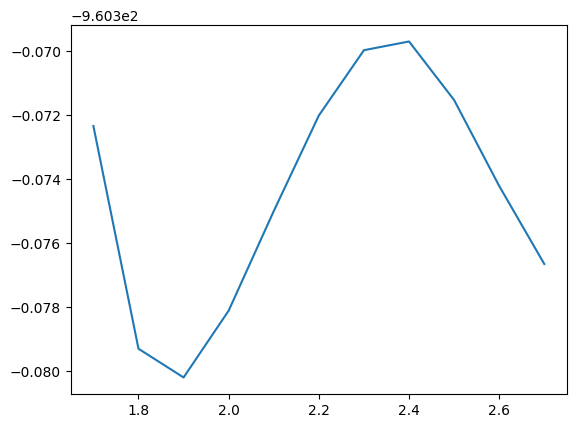

In [ ]:
plt.plot(distance, energies)

In [ ]:
# エネルギー最大値を与える距離を出力
idx = np.argmax(np.array(energies))
print(f'maximum energy at {distances[idx]: .1f} angstrom')

7

In [ ]:
print(geometries[idx])

-1 1
 C    0.000188776010   -0.048833136229    0.000000000000
 H   -0.536238399719   -0.000924608792   -0.929160277486
 H    1.073127894174   -0.000881140680    0.000000000000
 H   -0.536238399719   -0.000924608792    0.929160277486
CL   -0.000077124731   -2.334367432190    0.000000000000
CL   -0.000006421095    2.351203825522    0.000000000000



##### 遷移状態の最適化

In [ ]:
psi4.core.clean_options()
psi4.set_options({'OPT_TYPE': 'TS',
                  'GEOM_MAXITER': 100,
                  'OPT_COORDINATES': 'CARTESIAN',
                  'INTRAFRAG_STEP_LIMIT_MAX': 0.5,
                  'FULL_HESS_EVERY': 0,
                  'normal_modes_write': True})
psi4.set_output_file('SN2_OPT_TS.log')

PosixPath('SN2_OPT_TS.log')

In [ ]:
ts = psi4.geometry(geometries[7])
_, wfn_sn2 = optfreq(ts, 'b3lyp/6-31g(d)')

INFO:psi4.optking.optwrapper:Creating a UserComputer
INFO:psi4.optking.optwrapper:
    			-----------------------------------------

    			 OPTKING 3.0: for geometry optimizations 

    			     By R.A. King, Bethel University     

    			        with contributions from          

    			    A.V. Copan, J. Cayton, A. Heide      

    			-----------------------------------------

    
INFO:psi4.optking.optwrapper:
		 -- Optimization Parameters --
	H_guess_every                  =           False
	accept_symmetry_breaking       =           False
	alg_geom_maxiter               =             100
	bt_dx_conv                     =           1e-07
	bt_dx_rms_change_conv          =           1e-12
	bt_max_iter                    =              25
	cart_hess_read                 =           False
	consecutive_backsteps_allowed  =               0
	conv_max_DE                    =           1e-06
	conv_max_disp                  =          0.0012
	conv_max_force                 =          0.0003

INFO:psi4.driver.driver:Return gradient(): -960.369552492203
INFO:psi4.driver.driver:[[-0.00000324  0.00003897  0.00000000]
 [-0.00033998 -0.00005261 -0.00058776]
 [ 0.00068039 -0.00005026  0.00000000]
 [-0.00033998 -0.00005261  0.00058776]
 [-0.00000159  0.00008396  0.00000000]
 [-0.00000051  0.00003251  0.00000000]]
INFO:psi4.optking.history:	Performing BOFILL update.
INFO:psi4.optking.history:	Using 1 previous steps for update.
INFO:psi4.optking.history:	Steps to be used in Hessian update:  1

INFO:psi4.optking.history:	Updated Hessian (in au) 
 	   0.697813  -0.000027   0.000000  -0.140222   0.007846  -0.144633  -0.390127
	  -0.015734   0.000000  -0.140222   0.007846   0.144633  -0.015418   0.000055
	   0.000000  -0.011831   0.000016   0.000000
	  -0.000027  -0.035921   0.000000   0.004778  -0.007818   0.008297  -0.009571
	  -0.007829   0.000000   0.004778  -0.007818  -0.008297   0.000001   0.031893
	   0.000000  -0.000010   0.027503   0.000000
	   0.000000   0.000000   0.698104  -

Optimizer: Optimization complete!


INFO:psi4.driver.task_planner:PLANNING Atomic:  keywords={'SCF__D_CONVERGENCE': 1e-08, 'SCF__E_CONVERGENCE': 1e-08, 'FULL_HESS_EVERY': 0, 'GEOM_MAXITER': 100, 'INTRAFRAG_STEP_LIMIT_MAX': 0.5, 'SCF__INTS_TOLERANCE': 1e-12, 'NORMAL_MODES_WRITE': 1, 'OPT_COORDINATES': 'CARTESIAN', 'OPT_TYPE': 'TS', 'PARENT_SYMMETRY': 'CS(Z)', 'function_kwargs': {}}
INFO:psi4.driver.driver:Compute gradient(): method=b3lyp, basis=6-31g(d), molecule=CCl2H3, nre=108.57578271591338
INFO:psi4.driver.driver:Return gradient(): -960.3695542124341
INFO:psi4.driver.driver:[[-0.00006546 -0.00002693  0.00000000]
 [ 0.00007796  0.00001796  0.00007278]
 [-0.00010634  0.00000023  0.00000000]
 [ 0.00007796  0.00001796 -0.00007278]
 [ 0.00000435  0.00006077  0.00000000]
 [ 0.00000657 -0.00007023  0.00000000]]
INFO:psi4.driver.task_base:<<< JSON launch ... cs 108.57577829948943
INFO:psi4.driver.task_planner:PLANNING Atomic:  keywords={'SCF__D_CONVERGENCE': 1e-08, 'SCF__E_CONVERGENCE': 1e-08, 'FULL_HESS_EVERY': 0, 'GEOM_MAXI

In [ ]:
print(get_freqs(wfn_sn2))

[-329.0222871124382209  195.1018955111290722  195.1935600398248312
  211.4501640510802360  924.4845252158118001  924.6026013993157449
 1026.4286569256250914 1423.5110952898512551 1424.0708319230286634
 3234.0390187804364359 3429.4685686369330142 3429.5409279807086023]


In [ ]:
show_normal_modes('SN2_OPT_TS.CCl2H3.1004.molden_normal_modes')

interactive(children=(Dropdown(description='Normal mode:', options=((-329.0222871124, 0), (195.1018955111, 1),…

In [ ]:
print(ts.save_string_xyz())

-1 1
 C    0.243471047392    0.055984593807    0.000000000000
 H   -0.292613862163    0.030319307975   -0.930086497601
 H    1.316077033685    0.107249177664    0.000000000000
 H   -0.292613862163    0.030319307975    0.930086497601
CL    0.356877170765   -2.304213533562    0.000000000000
CL    0.130734523454    2.415767813584    0.000000000000



#### 簡単な遷移状態から始める

In [ ]:
ts_2 = psi4.geometry('''
-1 1
C        0.2649260080     -0.0067094977      0.0000000000
H       -0.2717752670     -0.0312506114     -0.9301314632
C        1.3381167522      0.0418605925      0.0000000000
C       -0.2717752670     -0.0312506114      0.9301314632
Cl       0.3727604714     -2.3688191841      0.0000000000
Cl       0.1571287303      2.3544767471      0.0000000000
H        1.6944025173      0.0582577786     -1.0088070112
H        1.7339248047     -0.8149079124      0.5041663560
H        1.6549282236      0.9306064646      0.5046397392
H       -1.3226464201     -0.0787576909      0.7343946575
H       -0.0531535919      0.8530376826      1.4915036894
H        0.0258452199     -0.8924765946      1.4910341746
''')

In [ ]:
show_3D(ts_2)

##### 制約付き最適化

In [ ]:
psi4.core.clean_options()
psi4.set_options({
    'GEOM_MAXITER': 200,
    'FROZEN_CARTESIAN': '1 XYZ 5 XYZ 6 XYZ'
})
psi4.set_output_file('SN2_OPT2.log')

In [ ]:
psi4.optimize('b3lyp/6-31g(d)', molecule=ts_2)

In [ ]:
show_3D(ts_2)

##### 遷移状態最適化

In [ ]:
psi4.core.clean_options()
psi4.set_options({
    'OPT_TYPE': 'TS',
    'GEOM_MAXITER': 100,
    'OPT_COORDINATES': 'CARTESIAN',
    'INTRAFRAG_STEP_LIMIT_MAX': 0.5,
    'FULL_HESS_EVERY': 0,
    'NORMAL_MODES_WRITE': True,
})
psi4.set_output_file('SN2_OPT_TS2.log')

In [ ]:
_, wfn_sn2_2 = optfreq(ts_2, 'b3lyp/6-31g(d)')

In [ ]:
print(get_freqs(wfn_sn2_2))

In [ ]:
show_3D(ts_2)

In [ ]:
ts_2.save_xyz_file('sn2_ts2.xyz', True)

In [ ]:
print(ts_2.save_string_xyz())

### IRC計算で反応経路を求めてみよう

In [ ]:
ts = psi4.geometry('''
-1 1
 C    0.098421320532    0.054893520710    0.000000000000
 H   -0.438222232952    0.050608630789   -0.930076170940
 H    1.172017644302    0.062780757659    0.000000000000
 H   -0.438222232952    0.050608630789    0.930076170940
CL    0.116749836102   -2.307797321210    0.000000000000
CL    0.078906733689    2.416696245111    0.000000000000
''')

In [ ]:
forward = ts.clone()

In [ ]:
psi4.core.clean_options()
psi4.set_options({
    'OPT_TYPE': 'IRC',
    'IRC_DIRECTION': 'FORWARD',
    'IRC_POINTS': 20,
    'IRC_STEP_SIZE': 0.2,
    'FULL_HESS_EVERY': 0,
    'OPT_COORDINATES': 'CARTESIAN',
    'GEOM_MAXITER': 200
                  })

In [ ]:
psi4.set_output_file('sn2_irc_forward.log')
psi4.optimize('b3lyp/6-31g(d)', molecule=forward)

INFO:psi4.optking.optwrapper:Creating a UserComputer
INFO:psi4.optking.optwrapper:
    			-----------------------------------------

    			 OPTKING 3.0: for geometry optimizations 

    			     By R.A. King, Bethel University     

    			        with contributions from          

    			    A.V. Copan, J. Cayton, A. Heide      

    			-----------------------------------------

    
INFO:psi4.optking.optwrapper:
		 -- Optimization Parameters --
	H_guess_every                  =           False
	accept_symmetry_breaking       =           False
	alg_geom_maxiter               =              50
	bt_dx_conv                     =           1e-07
	bt_dx_rms_change_conv          =           1e-12
	bt_max_iter                    =              25
	cart_hess_read                 =           False
	consecutive_backsteps_allowed  =               0
	conv_max_DE                    =           1e-06
	conv_max_disp                  =          0.0012
	conv_max_force                 =          0.0003

INFO:psi4.driver.driver:Return gradient(): -960.3695756110519
INFO:psi4.driver.driver:[[ 0.00011680 -0.00134681  0.00000000]
 [ 0.00006403  0.00002002  0.00003538]
 [-0.00021541 -0.00002675  0.00000000]
 [ 0.00006403  0.00002002 -0.00003538]
 [-0.00000727  0.00076624  0.00000000]
 [-0.00002690  0.00056666  0.00000000]]
INFO:psi4.optking.molsys:Projected (PHP) Hessian matrix
	   0.699773   0.005665   0.000000  -0.140519  -0.001062  -0.145014  -0.392204
	  -0.002851   0.000000  -0.140519  -0.001062   0.145014  -0.013256  -0.000340
	   0.000000  -0.013275  -0.000350   0.000000
	   0.005665  -0.038232   0.000000  -0.001050  -0.006988  -0.001162  -0.002861
	  -0.007003   0.000000  -0.001050  -0.006988   0.001162  -0.000344   0.029601
	   0.000000  -0.000360   0.029611   0.000000
	   0.000000   0.000000   0.699618  -0.144896  -0.001126  -0.308078   0.000000
	   0.000000  -0.056953   0.144896   0.001126  -0.308078   0.000000   0.000000
	  -0.013232   0.000000   0.000000  -0.013278
	  -0.14051

Optimizer: Optimization complete!
[{'step_number': 0, 'q': [0.0009155772733453584, 0.0007060647923375058, 0.0, -1.0131937658038948, -0.00739120363608712, -1.7575892388910987, 2.0297185984969954, 0.015610782512539103, 0.0, -1.0131937658038948, -0.00739120363608712, 1.7575892388910987, 0.03555145198683493, -4.464132545563837, 0.0, -0.035961647311387346, 4.4638663762703805, 0.0], 'x': [[0.0009155772733453584, 0.0007060647923375058, 0.0], [-1.0131937658038948, -0.00739120363608712, -1.7575892388910987], [2.0297185984969954, 0.015610782512539103, 0.0], [-1.0131937658038948, -0.00739120363608712, 1.7575892388910987], [0.03555145198683493, -4.464132545563837, 0.0], [-0.035961647311387346, 4.4638663762703805, 0.0]], 'f_q': [-0.00010579638315485435, 3.9342702505077836e-05, 0.0, -9.031744476760417e-05, -2.522618000755486e-05, -8.1204227716139e-05, 0.00026846953818743247, 2.2136608644683338e-05, 0.0, -9.031744476760417e-05, -2.522618000755486e-05, 8.1204227716139e-05, 2.1160267726403974e-06, -0.0

-960.3691574731084